In [1]:
#-- Importing modules
import flopy
import numpy as np
import pandas as pd
import flopy.modflow as fpm
import flopy.utils as fpu
import flopy.mt3d as mt

flopy is installed in C:\Anaconda3\lib\site-packages\flopy


In [2]:
#-- Defining boundries for DIS package
Lx = 5000
Ly = 10000
nrow = 100
ncol = 100
top = 0
botm = -10
nlay = 1
delr = Ly / ncol
delc = Lx / nrow
delv = (top - botm) / nlay
perlen = 20

In [3]:
#--importing data file
df= pd.read_csv("coord.csv")
df["x/delr"] = ((df["x"] /delc)-1).round(decimals=0)
df["y/delc"] = ((df["y"] /delr)-1).round(decimals=0)
df = df.drop(["x", "y"], axis = 1)
df= df.rename_axis('ID').values
df

array([[30., 64.],
       [31., 53.],
       [23., 43.],
       [31., 34.],
       [ 1., 25.],
       [35., 23.],
       [ 1., 16.],
       [33., 15.],
       [ 1.,  5.],
       [26.,  4.],
       [37.,  1.],
       [32., 65.],
       [33., 53.],
       [28.,  5.],
       [30., 65.]])

In [4]:
#--Generating model name
model_name = 'Draft_SP'
mf = flopy.modflow.Modflow(model_name, exe_name='mf2005')

In [5]:
disc = flopy.modflow.ModflowDis(mf, nlay, nrow, ncol, delr=delr, delc=delc,
                               top=top, botm = botm, perlen = perlen, nstp = 1)

In [6]:
#--Output Control
spd = {(0, 0): ['print head', 'print budget', 'save head', 'save budget']}
oc = flopy.modflow.ModflowOc(mf, stress_period_data=spd, compact=True)

In [7]:
#--BCF File
laycon = 0 #Confined
tran = 1
bcf = flopy.modflow.mfbcf.ModflowBcf(mf, laycon = 0, tran = 1)

In [8]:
#--Defining Head Boundary Conditions
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
ibound[:, :, 0] = -1
ibound[:, :, -1] = -1
strt = np.ones((nlay, nrow, ncol), dtype=np.float32)
strt[:, :, 0] = 10.
strt[:, :, -1] = 10.
bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)

In [9]:
#-- PCG File
pcg = flopy.modflow.mfpcg.ModflowPcg(mf, mxiter = 20, iter1 = 30)

In [10]:
#chd
#[layer, row, column, shead, ehead]

chd = 10
chd_data = []
for c in range(99):
    dd = np.array([0, 0, c, chd, chd])
    chd_data.append(dd)
for c in range(100):
    dd = np.array([0, c, 99, chd, chd])
    chd_data.append(dd)
for c in range(99):
    dd = np.array([0, 99, c, chd, chd])
    chd_data.append(dd)
for c in range(1, 99):
    dd = np.array([0, c, 0, chd, chd])
    chd_data.append(dd)
stress_period = {0:chd_data}
#stress_period

In [11]:
chd = flopy.modflow.ModflowChd(mf, stress_period_data = stress_period)

In [12]:
#-- Defining Well Package

injection_rate = 0.00001
first_val = 0
wel_temp = []
for x in enumerate(df):
    temp_val = [first_val ,  x[1][0] , x[1][1] , injection_rate]
    wel_temp.append(temp_val)

print(wel_temp)
lrcQ = {0 :wel_temp}


[[0, 30.0, 64.0, 1e-05], [0, 31.0, 53.0, 1e-05], [0, 23.0, 43.0, 1e-05], [0, 31.0, 34.0, 1e-05], [0, 1.0, 25.0, 1e-05], [0, 35.0, 23.0, 1e-05], [0, 1.0, 16.0, 1e-05], [0, 33.0, 15.0, 1e-05], [0, 1.0, 5.0, 1e-05], [0, 26.0, 4.0, 1e-05], [0, 37.0, 1.0, 1e-05], [0, 32.0, 65.0, 1e-05], [0, 33.0, 53.0, 1e-05], [0, 28.0, 5.0, 1e-05], [0, 30.0, 65.0, 1e-05]]


In [13]:
fpm.ModflowWel(mf, stress_period_data=lrcQ)


    MODFLOW Well Package Class.

    Parameters
    ----------
    model : model object
        The model object (of type :class:`flopy.modflow.mf.Modflow`) to which
        this package will be added.
    ipakcb : int
        A flag that is used to determine if cell-by-cell budget data should be
        saved. If ipakcb is non-zero cell-by-cell budget data will be saved.
        (default is 0).
    stress_period_data : list of boundaries, or recarray of boundaries, or
        dictionary of boundaries
        Each well is defined through definition of
        layer (int), row (int), column (int), flux (float).
        The simplest form is a dictionary with a lists of boundaries for each
        stress period, where each list of boundaries itself is a list of
        boundaries. Indices of the dictionary are the numbers of the stress
        period. This gives the form of:

            stress_period_data =
            {0: [
                [lay, row, col, flux],
                [lay, r

In [14]:
#-- Linkag with mt3d
lmt = flopy.modflow.ModflowLmt(mf, output_file_name = 'mt3d_link.ftl')

In [15]:
#--Writing Input Files
mf.write_input()
#--And to run the model
mf.run_model()

FloPy is using the following  executable to run the model: C:\WRDAPP\mf2005.1\bin\mf2005.EXE

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: Draft_SP.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2020/09/04 15:33:51

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2020/09/04 15:33:51
 Elapsed run time:  0.120 Seconds

  Normal termination of simulation


(True, [])

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: No contour levels were found within the data range.
  # This is added back by InteractiveShellApp.init_path()


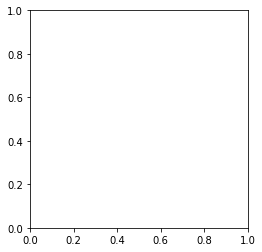

In [16]:
#To Plot Model Reults
#To Plot Model Reults
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf

#To creat the headfile object
headobj = bf.HeadFile(model_name + '.hds')
head = headobj.get_data(totim = 20)
times = headobj.get_times()
levels = np.linspace(1,2 , 3)
plt.contour(head[0, :, :], levels = levels)
plt.subplot(1,1,1, aspect = 'equal')

In [17]:
#MT3D-USGS
namemt3d='modelnamemt3d'
mt_model = mt.Mt3dms(modelname=namemt3d, version='mt3d-usgs', exe_name='MT3D-USGS_64.exe', modflowmodel=mf)

In [18]:
icbund = np.ones((nlay, nrow, ncol))
icbund[0, 30, 64] = -1
#icbund[0, 31, 53] = -1
#icbund[0, 23, 43] = -1
#icbund[0, 31, 34] = -1
#icbund[0, 1, 25] = -1
#icbund[0, 35, 23] = -1
#icbund[0, 1, 16] = -1
#icbund[0, 33, 15] = -1
#icbund[0, 1, 5] = -1
#icbund[0, 26, 4] = -1
#icbund[0, 37, 1] = -1
#icbund[0, 32, 65] = -1
#icbund[0, 33, 53] = -1
#icbund[0, 28, 5] = -1
#icbund[0, 30, 65] = -1

In [19]:
btn = flopy.mt3d.Mt3dBtn(mt_model, sconc=0.0, prsity=0.3, thkmin=0.01, munit='g', icbund=icbund)

In [20]:
#ADV file
mixelm = -1 # Advection solution option
percel = 1 # Courant number
adv = flopy.mt3d.Mt3dAdv(mt_model, mixelm=mixelm, percel=percel)

In [21]:
#GCG file
mxiter = 1 # Number of Outer Iterations
iter1 = 200 # Number of inner Iterations
isolve = 3  # Modified Incomplete Cholesky
gcg = flopy.mt3d.Mt3dGcg(mt_model, mxiter=mxiter, iter1=iter1, isolve=isolve)

In [22]:
#DSP file
al = 10 
dmcoef = 0 
trpt = 0.1 
trpv = 0.01


In [23]:
dsp = mt.Mt3dDsp(mt_model, al=al, dmcoef=dmcoef, trpt=trpt, trpv=trpv)

In [24]:
#SSM file
itype = flopy.mt3d.Mt3dSsm.itype_dict
ssm_data = {}
ssm_data[0] = [(0, 30, 64, 1.0, 2)]
ssm_data[0].append((0, 30, 64, 1.0, -1))
ssm = flopy.mt3d.Mt3dSsm(mt_model, stress_period_data=ssm_data)

In [25]:
#Write model input
mt_model.write_input()

#Run the model
mt_model.run_model()

FloPy is using the following  executable to run the model: C:\Anaconda3\mt3dusgs1.1.0\bin\MT3D-USGS_64.exe

 MT3D-USGS - Modular 3D Multi-Species Transport Model [Ver 1.1.0]   
 and based on MT3DMS. MT3D-USGS developed in cooperation by 
 S.S. Papadopulos & Associates and the U.S. Geological Survey

 Using NAME File: modelnamemt3d.nam

 STRESS PERIOD NO.    1

 TIME STEP NO.    1
 FROM TIME =   0.0000     TO    20.000    

 Transport Step:    1   Step Size:   20.00     Total Elapsed Time:   20.000    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1324E-08  [K,I,J]    1   30   65

 Program completed.   Total CPU time:  000 minutes  0.062 seconds


(False, [])

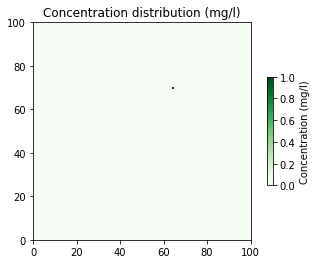

In [26]:
import flopy.utils as fu
conc = fu.UcnFile('MT3D001.UCN')
conc.plot(totim=times[-1], colorbar='Concentration (mg/l)', cmap='Greens')
plt.title('Concentration distribution (mg/l)')
plt.show()